<a href="https://colab.research.google.com/github/harshitadd/Celestini/blob/master/Modeltf.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install joblib
import tensorflow as tf 
import pickle
#from sklearn.externals import joblib
import numpy as np
from tensorflow.python.client import device_lib
from tensorflow.saved_model import simple_save
import random
import matplotlib.pyplot as plt 
import math
import warnings
from sklearn.model_selection import train_test_split
from tensorflow.python import pywrap_tensorflow


In [148]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
## 64 BIT (2253,4016)
'''
with open('/content/drive/My Drive/ffeatures64.bin','rb') as file:
  features = pickle.load(file)
with open('/content/drive/My Drive/flabels64.bin','rb') as file:
  labels = pickle.load(file)
'''

In [0]:
## 48 BIT (2253,2315)
'''
features = joblib.load('/content/features48.pkl')
labels = joblib.load('/content/labels48.pkl')
'''

In [0]:
## 56 BIT (2253,3147)

features = joblib.load('/content/features56.pkl')
labels = joblib.load('/content/labels56.pkl')


In [0]:
## 64 BIT (2253,3147)

features = joblib.load('/content/features64.pkl')
labels = joblib.load('/content/labels64.pkl')


In [0]:
## 32 BIT (2253,1035)
'''
features = joblib.load('/content/features32.pkl')
labels = joblib.load('/content/labels32.pkl') '''

In [0]:
## 16 BIT (2253,267)
'''
features = joblib.load('/content/features16.pkl')
labels = joblib.load('/content/labels16.pkl')
'''

In [220]:
# print(features[0])
# print(len(features[0]))
# print(len(features))
print(np.shape(features))

(2253, 4107)


In [0]:
## TEST SET 

x_train_t, x_test_t,y_train_t, y_test_t = train_test_split(features, labels, test_size = 0.3)

In [0]:
tf.reset_default_graph()

In [210]:
print(device_lib.list_local_devices())


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14897724422501250088
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 14031993209263849258
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11853421497831758623
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14892338381
locality {
  bus_id: 1
  links {
  }
}
incarnation: 13929497170043991562
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


In [0]:
x = tf.placeholder(shape = (None,4107), dtype = tf.float32, name = 'input' )
y = tf.placeholder(shape = (None,1), dtype = tf.float32, name = 'target')

wh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((4107, 500)))
bh = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,500)))

#out

wo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((500,1)))
bo = tf.Variable(tf.glorot_uniform_initializer(dtype = tf.float32)((1,1)))


                

In [0]:
hidl = tf.add(tf.matmul(x,wh),bh, name ='hidden1')

In [0]:
outl = tf.add(tf.matmul(hidl,wo),bo,name = 'output')

Add additional custom loss functions if necc 
reducing mean sqaure error 
1. reducing max deviation 

In [0]:
loss = tf.reduce_mean(tf.square(tf.subtract(y,outl))) + 0.3*tf.reduce_max(tf.subtract(y,outl))
#default lr = 0.001
opt = tf.train.AdamOptimizer(name = 'optimizer')
op_train = opt.minimize(loss, name ='train_op')

In [0]:
saved = tf.train.Saver().as_saver_def()

In [0]:
init = tf.global_variables_initializer()

In [230]:
train=[]
val=[]
with tf.device('/device:CPU:0'):
  save = tf.train.Saver()
  with tf.Session() as sess:
    sess.run(init)
    mini =[]
    for i in range(0,1000):
      b1=[]
      b2=[]
      l1=[]
      l2=[]
      b1_val=[]
      b2_val=[]
      l1_val=[]
      l2_val=[]
      x_traint, x_test_t,y_traint, y_test_t = train_test_split(features, labels, test_size = 0.3)
      x_trainv, x_testv, y_trainv, y_testv = train_test_split(x_traint, y_traint, test_size = 0.3)
      
      for j in range(16): ##One run is appending 2 random lists 
        
        ##TRAINING MINI BATCHES 
        
        seed = random.choice(range(len(x_trainv)))
        i = random.choice(range(len(x_trainv)))
        
        b1.append(x_trainv[seed])
        b2.append(x_trainv[i])
        l1.append(y_trainv[seed])
        l2.append(y_trainv[i])
        
        x_batch = np.vstack((b1,b2))
        y_batch = np.vstack((l1,l2))
        
        ##VALIDATION MINI BATCHES 
        
        seed_val = random.choice(range(len(x_traint)))
        i_val = random.choice(range(len(x_traint)))
        
        b1_val.append(x_traint[seed_val])
        b2_val.append(x_traint[i_val])
        l1_val.append(y_traint[seed_val])
        l2_val.append(y_traint[i_val])
        
        x_batch_val = np.vstack((b1_val,b2_val))
        y_batch_val = np.vstack((l1_val,l2_val))
      
      ## TRAINING LOSS
      z= sess.run([loss,op_train], feed_dict = {x : x_batch, y: y_batch })
      train.append(z[0])
      ##VALIDATION LOSS
      z_val= sess.run([loss], feed_dict = {x : x_batch_val, y: y_batch_val })
      val.append(z_val[0])
      
      print(str(z[0]) + '\t' + str(z_val[0]))
    
    
    simple_save(sess,'/content/drive/My Drive/Custom_Models/model1000_64',inputs = {'input' : x}, outputs = {'output': outl})
    print('Saved model!')
    

2953.1438	1417.9336
991.08856	2123.0542
2537.4731	662.5834
1210.7762	983.6121
2822.5818	767.1733
902.0491	225.91055
280.24036	1019.5154
1784.0277	678.28894
232.84415	394.37347
345.4839	397.41922
339.3804	244.6647
1169.6362	313.22916
389.1945	751.1205
824.6557	1123.7117
246.87297	306.66998
247.56046	604.8666
865.13586	186.99649
504.05167	297.87262
264.13855	882.89465
801.1144	1216.118
683.297	815.1374
1512.9529	715.34625
1138.7932	383.31686
674.1432	1647.2062
416.84283	669.5109
650.62756	240.06657
747.96277	175.08006
827.5389	1217.7827
698.75684	641.31445
133.35124	445.7707
231.6333	1601.6642
630.9935	1419.4198
1282.4236	241.5539
823.72394	313.21356
476.3082	875.701
603.05414	224.07117
279.4546	200.12256
748.5566	936.47406
741.1218	759.71533
1086.7198	203.01042
645.8998	216.7098
1060.8065	229.90268
219.98375	278.7602
223.29619	254.57558
205.99217	203.67024
237.25908	526.078
325.98965	304.53357
259.47748	519.94806
1214.9708	305.42343
815.61816	771.33124
726.8644	471.51044
1025.6401	606.3

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_64.pb', 'wb') as f:
  f.write(tf.get_default_graph().as_graph_def().SerializeToString())

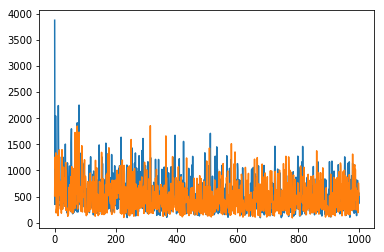

In [205]:
plt.plot(train)
plt.plot(val)

In [183]:
tf.trainable_variables()

[<tf.Variable 'Variable:0' shape=(1035, 500) dtype=float32_ref>,
 <tf.Variable 'Variable_1:0' shape=(1, 500) dtype=float32_ref>,
 <tf.Variable 'Variable_2:0' shape=(500, 1) dtype=float32_ref>,
 <tf.Variable 'Variable_3:0' shape=(1, 1) dtype=float32_ref>]

In [0]:
with open('/content/drive/My Drive/Custom_Models/graph1000_updatedloss.pb', 'rb') as f:
  g1 = f.read()
with open('/content/drive/My Drive/Custom_Models/graph1000.pb', 'rb') as f:
  g2 = f.read()

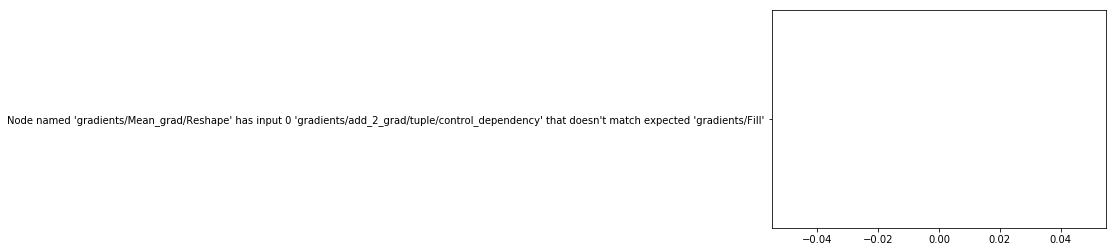

In [146]:
diff = pywrap_tensorflow.EqualGraphDefWrapper(g1,g2) 
#plt.plot(diff)